# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (16.0, 8.0)
cp = sns.color_palette()

In [2]:
PATH_TO_DATA = "nlp_project/data/"

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word.upper()] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        words = []
        scores = []
        for word in self.word2id:
            words.append(word)
            scores.append(self.score(w, word))
        words = np.array(words)
        scores = np.array(scores)
        sorted_index = np.argsort(-scores)  # sort -scores to have descending sorting for scores
        return words[sorted_index[1:K+1]]

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        v1 = self.word2vec.get(w1.upper())
        v2 = self.word2vec.get(w2.upper())
        den = np.linalg.norm(v1) * np.linalg.norm(v2)
        return np.dot(v1, v2) / den


In [4]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2)
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w1, " most similar to :")
    print(w2v.most_similar(w1))

Loaded 19765 pretrained word vectors
cat dog
cat dog 0.25109368796701387
dog pet
dog pet 0.2814974489576861
dogs cats
dogs cats 0.6747577573530964
paris france
paris france 0.7058595452409974
germany berlin
germany berlin 0.7060253015336013
cat  most similar to :
['MAN' 'SAT' 'PET' 'ACT' 'STAR']
dog  most similar to :
['DOGS' 'PUPPY' 'CANINE' 'HORSE' 'PETS']
dogs  most similar to :
['DOG' 'PETS' 'CATS' 'ANIMALS' 'HORSES']
paris  most similar to :
['PARISIAN' 'FRANCE' 'VERSAILLES' 'LYON' 'BORDEAUX']
germany  most similar to :
['AUSTRIA' 'BAVARIA' 'BERLIN' 'MUNICH' 'HAMBURG']


In [23]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
        self._emb_dim = w2v.word2vec.get("CAT").shape[0]
    
    def encode(self, sentences, idf=None):
        sentemb = np.zeros((len(sentences), self._emb_dim))
        for i, sent in enumerate(sentences):
            emb = np.zeros(self._emb_dim)
            count = 0
            if idf is None:
                for word in sent.strip().split(' '):
                    word = word.upper()
                    if word in self.w2v.word2vec.keys():
                        contrib = self.w2v.word2vec.get(word)
                        emb += contrib
                        count += 1
                sentemb[i, :] = emb / count
            else:
                for word in sent.strip().split(' '):
                    word = word.upper()
                    if word in self.w2v.word2vec.keys() and word in idf.keys():
                        contrib = self.w2v.word2vec.get(word)
                        emb += contrib * idf.get(word)
                        count += idf.get(word)
                sentemb[i, :] = emb / count
        return sentemb

    def most_similar(self, s, sentences, idf=None, K=5):
        # get most similar sentences and **print** them
        scores = []
        for i in range(len(sentences)):
            scores.append(self.score(s, sentences[i], idf))
        scores = np.array(scores)
        sorted_index = np.argsort(-scores)
        for k in sorted_index[1:K+1]:
            print(f"({scores[k]:.2f}, {k}) : {sentences[k]}")

    def score(self, s1, s2, idf=None):
        v1 = self.encode([s1], idf)[0, :]
        v2 = self.encode([s2], idf)[0, :]
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        from collections import defaultdict
        idf = defaultdict(float)
        for sentence in sentences:
            for w in set(w.upper() for w in sentence.strip().split(' ')):
                idf[w] += 1
        for w in idf:
            idf[w] = max(1, np.log10(len(sentences) / idf[w]))
        return idf


In [25]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = np.loadtxt(f"{PATH_TO_DATA}/sentences.txt", delimiter='\n', dtype='str').tolist()

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))


idf = s2v.build_idf(sentences)
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 4367 pretrained word vectors


/home/valentin/anaconda3/envs/thera/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


(0.94, 135564) : two people are swimming in a pool . 
(0.91, 128) : 2 men are swimming in a pool in separate lanes as if racing . 
(0.91, 112512) : some people are sitting in a watery pool beside the river . 
(0.91, 102594) : many people are in an indoor swimming pool and one girl is in the act of jumping in headfirst . 
(0.91, 110030) : seven people are wading in a natural pool . 
0.8421031884549606


/home/valentin/anaconda3/envs/thera/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


(0.89, 135564) : two people are swimming in a pool . 
(0.87, 33227) : a man and a boy are in the swimming pool . 
(0.87, 135285) : two people are in a swimming pool with water splashing around . 
(0.87, 100269) : man and boy are swimming in a pool . 
(0.87, 101200) : man in swimming pool holding 2 children . 
0.7341256858340702


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size $V_a$ (e.g French-English).

Let's define  X  and Y the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : $W^* = \text{argmin} || W.X - Y || \text{  s.t  } W^T.W = \text{Id}$
has a closed form solution:
$W = U.V^T$  where $U.\Sigma.V^T = \text{SVD}(Y.X^T)$

In what follows, you are asked to: 

In [28]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE

with open(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), encoding='utf-8') as en_f:
    wiki_eng = {}
    next(en_f)  # Skip headers
    for i, line in enumerate(en_f):
        if i == 50000:
            break
        word, data = line.split(' ', maxsplit=1)
        wiki_eng[word.upper()] = np.fromstring(data, sep=' ')

with open(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), encoding='utf-8') as fr_f:
    wiki_fr = {}
    next(fr_f)  # Skip headers
    for i, line in enumerate(fr_f):
        if i == 50000:
            break
        word, data = line.split(' ', maxsplit=1)
        wiki_fr[word.upper()] = np.fromstring(data, sep=' ')

In [38]:
wiki_eng["BJÖRN"].shape

(300,)

In [44]:
len(set(wiki_eng.keys()).intersection(set(wiki_fr.keys())))

18968

In [46]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

common_words = set(wiki_eng).intersection(set(wiki_fr))
X = np.zeros((wiki_eng["BJÖRN"].shape[0], len(common_words)))
Y = np.zeros((wiki_eng["BJÖRN"].shape[0], len(common_words)))
for j, w in enumerate(common_words):
    X[:, j] = wiki_fr[w]
    Y[:, j] = wiki_eng[w]

In [48]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

from scipy import linalg

U, sig, V = scipy.linalg.svd(np.dot(Y, np.transpose(X)))
W = np.dot(U, V)

In [64]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

def get_nearest_translations(W, src_word, target_words, K=5):
    translation = np.dot(W, src_word)
    words = []
    scores = []
    for w, v in wiki_eng.items():
        words.append(w)
        scores.append(np.dot(translation, v) / (np.linalg.norm(v) * np.linalg.norm(translation)))
    words = np.array(words)
    scores = np.array(scores)
    sorted_index = np.argsort(- scores)
    return words[sorted_index[:K]]

np.random.seed(seed=10)
fr_words = list(wiki_fr.keys())
samples = np.random.choice(np.array(range(len(fr_words))), size=20, replace=False)
for i in samples:
    print(f"{fr_words[i]} : ", end='')
    neighs = get_nearest_translations(W, wiki_fr[fr_words[i]], wiki_eng)
    print(', '.join(neighs))

SOLUBLES : SOLUBLE, INSOLUBLE, SALTS, HYDROXIDE, SOLVENTS
FINLAY : FINLAY, ORTON, LAWLER, PRINGLE, SANDERSON
LAURA : LAURA, MARISA, GINA, AMANDA, JENNIFER
CLAPTON : CLAPTON, JAGGER, BEATLES, KNOPFLER, GROHL
CHABAN : CHIRAC, MITTERRAND, HOLLANDE, GAILLARD, GAULLE
MALFORMATION : CONGENITAL, ABNORMALITY, ABNORMALITIES, DYSPLASIA, TESTICULAR
FRÉQUENTE : FREQUENTED, STUDIED, FREQUENT, ACQUAINTED, BEFRIENDED
ADJACENT : ADJACENT, ADJOINING, ADJOINS, OCCUPIES, NEARBY
ARGO : ARGO, ORION, POSEIDON, DAEDALUS, TRITON
MEURTRIÈRES : EMPLACEMENTS, BASTIONS, DOORWAYS, PARAPET, RAMPARTS
CORPORATE : CORPORATE, CORPORATIONS, CORPORATION, BUSINESS, CONSULTANCY
TENTENT : CONFRONT, THWART, CONVINCE, REGROUP, PERSUADE
JULIAN : JULIAN, BARRY, TOBY, RHYS, SEBASTIAN
NAPOLÉONIEN : NAPOLEONIC, NAPOLEON, NAPOLÉON, ANCIEN, BONAPARTE
DISPARUE : DEFUNCT, DISAPPEARED, DISAPPEARANCE, VANISHED, HACHETTE
LATÉRAL : LATERAL, LATERALLY, SEMICIRCULAR, MIDLINE, ANTERIOR
ALPHABET : ALPHABET, ALPHABETS, ORTHOGRAPHY, PHONETIC, D

If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [74]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

w2v = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)

def load_sentiment(filename, test=False):
    file = np.loadtxt(f"{PATH_TO_DATA}SST/{filename}", delimiter='\n', dtype='str').tolist()
    x = []
    y = []
    if test:
        return file
    for l in file:
        target, sentence = l.split(' ', 1)
        x.append(sentence.strip())
        y.append(int(target))
    return x, y

dev_x, dev_y = load_sentiment('stsa.fine.dev')
train_x, train_y = load_sentiment('stsa.fine.train')
test_x = load_sentiment('stsa.fine.test.X', test=True)

Loaded 49996 pretrained word vectors


In [75]:
# 2 - Encode sentences with the BoV model above

s2v = BoV(w2v)
idf_bov = BoV.build_idf(BoV, train_x)

# Encoding
train_enc = s2v.encode(train_x, idf_bov)
dev_enc = s2v.encode(dev_x, idf_bov)
test_enc = s2v.encode(test_x, idf_bov)

In [82]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

from sklearn.linear_model import LogisticRegression
cl = LogisticRegression(penalty='l2')
cl.fit(train_enc, np.array(train_y))

/home/valentin/anaconda3/envs/thera/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/valentin/anaconda3/envs/thera/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [91]:
print(f"Accuracy: {cl.score(dev_enc, np.array(dev_y)):.2f}")
print(f"Mean absolute distance from target class: {np.mean(np.abs(dev_y - cl.predict(dev_enc))):.2f}")

Accuracy: 0.40
Mean absolute distance from target class: 0.85


In [87]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

test_pred = cl.predict(test_enc)
np.savetxt("logreg_bov_y_test_sst.txt", test_pred.astype('int'), encoding='utf-8', fmt="%d")

In [9]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [92]:
import keras

Using TensorFlow backend.


In [11]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "nlp_project/data/"

def load_sentiment(filename, test=False):
    file = np.loadtxt(f"{PATH_TO_DATA}SST/{filename}", delimiter='\n', dtype='str').tolist()
    x = []
    y = []
    if test:
        return file
    for l in file:
        target, sentence = l.split(' ', 1)
        x.append(sentence.strip())
        y.append(int(target))
    return x, y

dev_x, dev_y = load_sentiment('stsa.fine.dev')
train_x, train_y = load_sentiment('stsa.fine.train')
test_x = load_sentiment('stsa.fine.test.X', test=True)

In [101]:
words = set()
for s in dev_x + train_x + test_x:
    for w in s.split(' '):
        words.add(w.lower())
print("Number of words in the corpus: " + str(len(words)))
del words

Number of words in the corpus: 19537


In [102]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
enc_train = [keras.preprocessing.text.one_hot(s, split=' ', n=19600) for s in train_x]
enc_dev = [keras.preprocessing.text.one_hot(s, split=' ', n=19600) for s in dev_x]

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [107]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

maxlen = max(len(s.split(' ')) for s in dev_x + train_x + test_x)
x_train = keras.preprocessing.sequence.pad_sequences(enc_train, padding='pre', maxlen=maxlen)
x_dev = keras.preprocessing.sequence.pad_sequences(enc_dev, padding='pre', maxlen=maxlen)

## 4.2 - Design and train your model

In [211]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW


from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, Bidirectional

embed_dim  = x_train.shape[1]
nhid       = 30  # number of hidden units in the LSTM
vocab_size = 19600  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.4, recurrent_dropout=0.4))
# model.add(Bidirectional(LSTM(nhid, dropout_W=0.2, dropout_U=0.2), merge_mode='concat'))
model.add(Dense(n_classes, activation='sigmoid'))


In [212]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' 
optimizer        =  'adam'
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, None, 56)          1097600   
_________________________________________________________________
lstm_30 (LSTM)               (None, 30)                10440     
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 155       
Total params: 1,108,195
Trainable params: 1,108,195
Non-trainable params: 0
_________________________________________________________________
None


In [213]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 120
n_epochs = 8

history = model.fit(x_train, keras.utils.to_categorical(train_y), batch_size=bs, epochs=n_epochs, 
                    validation_data=(x_dev, keras.utils.to_categorical(dev_y)))

Train on 8544 samples, validate on 1101 samples
Epoch 1/8
8544/8544 [==============================] - 7s 852us/step - loss: 1.5847 - acc: 0.2578 - val_loss: 1.5717 - val_acc: 0.2579
Epoch 2/8
8544/8544 [==============================] - 3s 364us/step - loss: 1.5577 - acc: 0.3064 - val_loss: 1.5616 - val_acc: 0.2761
Epoch 3/8
8544/8544 [==============================] - 3s 371us/step - loss: 1.5005 - acc: 0.3558 - val_loss: 1.5050 - val_acc: 0.3415
Epoch 4/8
8544/8544 [==============================] - 3s 382us/step - loss: 1.3542 - acc: 0.4464 - val_loss: 1.4678 - val_acc: 0.3669
Epoch 5/8
8544/8544 [==============================] - 3s 377us/step - loss: 1.1787 - acc: 0.5210 - val_loss: 1.4770 - val_acc: 0.3560
Epoch 6/8
8544/8544 [==============================] - 3s 374us/step - loss: 1.0334 - acc: 0.5989 - val_loss: 1.5736 - val_acc: 0.3642
Epoch 7/8
8544/8544 [==============================] - 3s 398us/step - loss: 0.9133 - acc: 0.6572 - val_loss: 1.6814 - val_acc: 0.3642
Epoch 8

We have an overfitting problem as the training accuracy ends up much higher than the validation accuracy. On the graph below we can see that the network stops learning useful features and starts overfitting after 3 epochs.

However regularization not only reduces learning rate but actually worsen the issue. Increasing dropout and decreasing the complexity of the model by reducing the number of hidden units don't seem to improve the results on the validation set either. After these infructuous attempts to reduce overfitting, we kept the overfitting model with the highest accuracy on validation set.

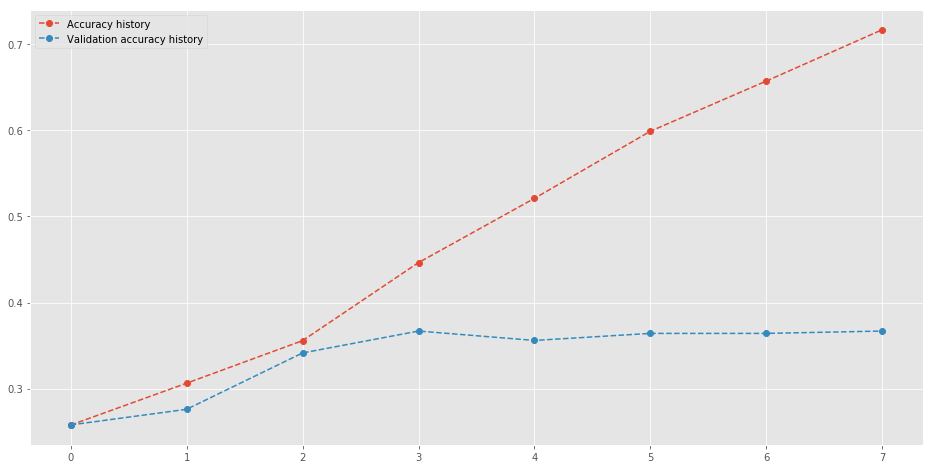

In [218]:
plt.plot(range(n_epochs), history.history["acc"], "--o", label="Accuracy history")
plt.plot(range(n_epochs), history.history["val_acc"], "--o", label="Validation accuracy history")
plt.legend()
plt.show()

In [215]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
enc_test = [keras.preprocessing.text.one_hot(s, split=' ', n=19600) for s in test_x]
x_test = keras.preprocessing.sequence.pad_sequences(enc_test, padding='pre', maxlen=maxlen)
y_test = np.argmax(model.predict(x_test), axis=1)
np.savetxt("logreg_lstm_y_test_sst.txt", y_test.astype('int'), encoding='utf-8', fmt='%d')

## 4.3 -- innovate !

In [217]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

embed_dim  = x_train.shape[1]
nhid       = 60  # number of hidden units in the LSTM
vocab_size = 19600  # size of the vocabulary
n_classes  = 5

model_2 = Sequential()
model_2.add(Embedding(vocab_size, embed_dim))
# model.add(LSTM(nhid, dropout=0.4, recurrent_dropout=0.4))
model_2.add(Bidirectional(LSTM(nhid, dropout=0.5, recurrent_dropout=0.5), merge_mode='concat'))
model_2.add(Dense(n_classes, activation='sigmoid'))

loss_classif     =  'categorical_crossentropy' 
optimizer        =  'adam'
metrics_classif  =  ['accuracy']

model_2.compile(loss=loss_classif,
                optimizer=optimizer,
                metrics=metrics_classif)
print(model_2.summary())

bs = 120
n_epochs = 8

history_2 = model_2.fit(x_train, keras.utils.to_categorical(train_y), batch_size=bs, epochs=n_epochs, 
                        validation_data=(x_dev, keras.utils.to_categorical(dev_y)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, None, 56)          1097600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 120)               56160     
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 605       
Total params: 1,154,365
Trainable params: 1,154,365
Non-trainable params: 0
_________________________________________________________________
None
Train on 8544 samples, validate on 1101 samples
Epoch 1/8
8544/8544 [==============================] - 10s 1ms/step - loss: 1.5752 - acc: 0.2690 - val_loss: 1.5723 - val_acc: 0.2534
Epoch 2/8
8544/8544 [==============================] - 7s 794us/step - loss: 1.5588 - acc: 0.2924 - val_loss: 1.5417 - val_acc: 0.3206
Epoch 3/8
8544/8544 [==============================] - 8s 934us/step - los

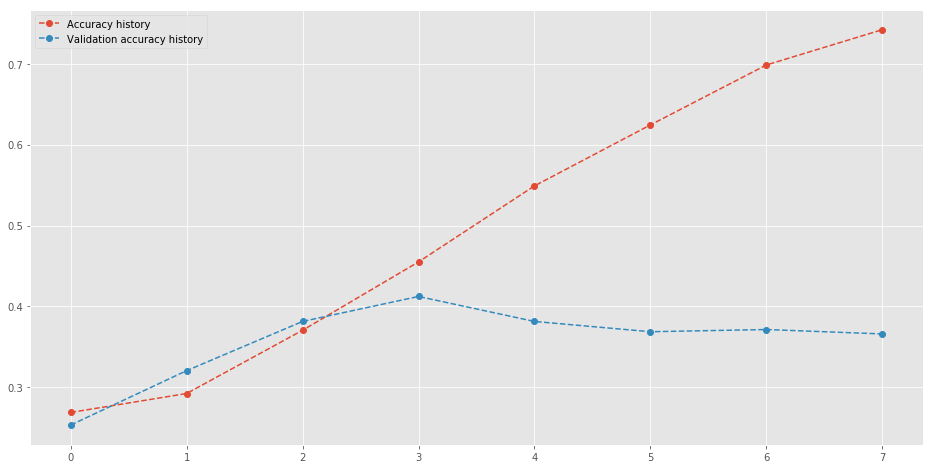

In [219]:
plt.plot(range(n_epochs), history_2.history["acc"], "--o", label="Accuracy history")
plt.plot(range(n_epochs), history_2.history["val_acc"], "--o", label="Validation accuracy history")
plt.legend()
plt.show()